# Single Segmentation Model

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

from dataset import PlantDataset, get_binary_target

from utils import (
    display_batch_masks,
    upscale_logits, # quizas deberian ir al modulo del modelo?
    flatten_logits, # quizas deberian ir al modulo del modelo
    set_seed,
    )

from evaluation import compute_intersection_over_union

from transformers import (
    SegformerForSemanticSegmentation,
    SegformerFeatureExtractor
)

from PIL import Image 
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Load Functions

For any explanation and usage of the functions below, please see
`playground.ipynb` in the root directory.


In [2]:
dataset = PlantDataset('data', 'cwt', 'data_inventary.csv')
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")

def collate_fn(batch, target_fn=get_binary_target):
    """
        Collate function to stack the masks as channels in the same tensor.
        get_target: function to get the target tensor from the masks and labels
            could be multi-labeling or binary.
    """ 
    # Acá se pueden agregar todas las transformacaiones adicionales de preproceso
    # que se requieran para las máscaras. Lo única esencial es pasar una PIL.Image
    # a tensor
    tfms = ToTensor()
    images = torch.cat([feature_extractor(example['image'], return_tensors='pt')['pixel_values'] for example in batch])
    masks = [example['masks'] for example in batch]
    labels = [example['labels'] for example in batch]
    targets = torch.cat([target_fn(x[0], x[1], tfms, size=(512,512)) for x in zip(masks, labels)])

    # transformar a 1 cuando haya un entero distinto a 0 (semantic segmentation)
    targets = torch.where(targets > 0.0, 1.0, 0.0)
    return images, targets

/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## Train a single batch

In [3]:
set_seed(42313988)  # for reproducibility
BS = 4      # Batch size
lr = 1e-3 

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

dataloader = DataLoader(dataset, batch_size=BS, shuffle=True, num_workers=0,
                        collate_fn = 
                        lambda x: collate_fn(x, target_fn=get_binary_target))

xb, yb = next(iter(dataloader))

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c

(torch.Size([4, 3, 512, 512]), torch.Size([4, 1, 512, 512]))

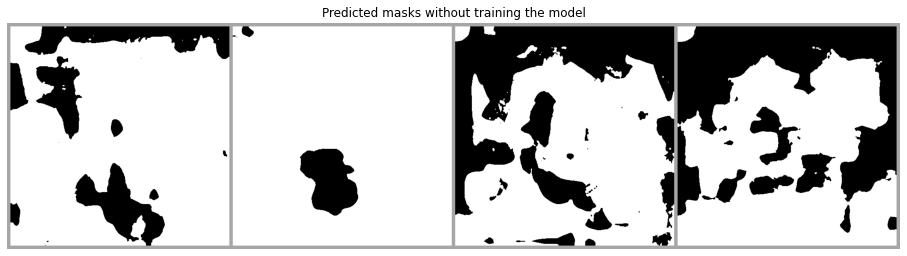

In [4]:
model.eval()
preds = torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu()
display_batch_masks(preds, caption=f'Predicted masks without training the model')

In [8]:
n_epochs = 50
eval_steps=10

# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
lossi = np.zeros(n_epochs)
cur_iou = []
for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities (slower way)
  #loss = loss_fn(upscale_logits(logits), yb)

  # compute the loss with class indices (faster way)
  #loss = loss_fn(upscale_logits(logits),
  #               torch.argmax(yb, dim=1).to(torch.long))

  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  cur_loss = loss.item()
  cur_iou.append(compute_intersection_over_union(logits.float(), yb.float()))
  lossi[idx] = cur_loss

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%eval_steps== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f} | mIoU: {np.mean(cur_iou):.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")


plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("Loss");

Random seed set as 42313988


  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 3.95 GiB total capacity; 3.29 GiB already allocated; 29.50 MiB free; 3.33 GiB reserved in total by PyTorch)

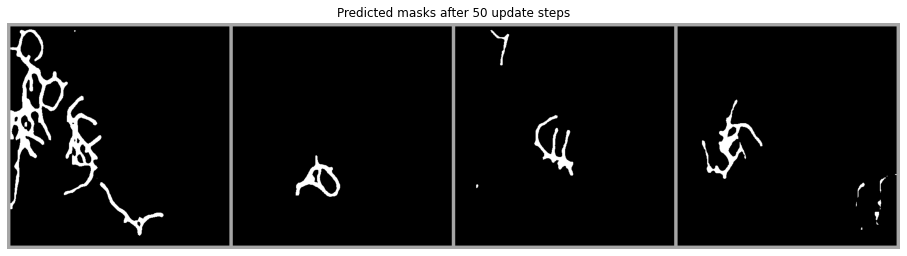

In [6]:
model.eval()
logits = upscale_logits(model(xb)["logits"])
preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).unsqueeze(1).cpu()
display_batch_masks(preds, caption=f'Predicted masks after {n_epochs} update steps')

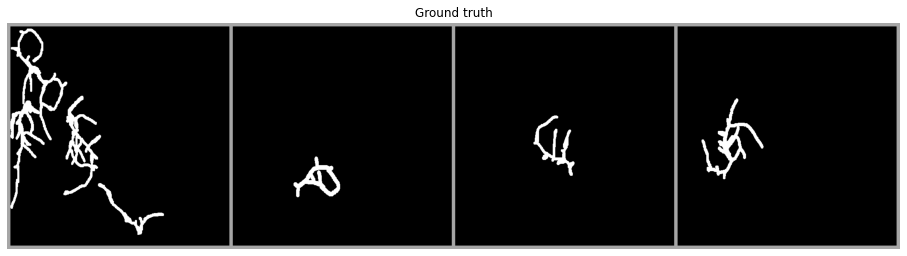

In [7]:
display_batch_masks(yb.max(dim=1)[0].unsqueeze(1).cpu(), caption='Ground truth')